In [1]:
using Distributions
using RCall
using Roots
using StatsFuns

safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
# odds ratio Wald test

oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [3]:
# risk ratio Wald test

riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

confint_rr_wald (generic function with 1 method)

In [4]:
# odds ratio Pearson's χ²-test (score test)

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [5]:
# risk ratio Pearson's χ²-test (score test)

function Delta(a, b, c, d; ρ=1)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    isinf(ρ) ? typeof(ω)(-c) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    RRhat = riskratiohat(a, b, c, d)
    if a == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif c == 0
        [exp(find_zero(f, 0.0)), Inf]
    elseif b == 0
        [0.0, exp(find_zero(f, log(2RRhat)))]
    elseif d == 0
        [exp(find_zero(f, log(RRhat/2))), Inf]
    else
        ρ_L, ρ_U = RRhat/2, 2RRhat
        [exp(find_zero(f, log(ρ_L))), exp(find_zero(f, log(ρ_U)))]
    end
end

confint_rr_pearson_chisq (generic function with 1 method)

In [6]:
# Fisher test (Clopper-Pearson)

function pvalue_or_fisher_cp(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2cdf(fnch, a), 2ccdf(fnch, a-1))
end

function confint_or_fisher_cp(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = logit(pvalue_or_fisher_cp(a, b, c, d; ω)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_fisher_cp (generic function with 1 method)

In [7]:
# Fisher test (Sterne)

_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_fisher_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(fnch, a)
end

function confint_or_fisher_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_fisher_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end

confint_or_fisher_sterne (generic function with 1 method)

In [8]:
R"""fisher.test(matrix(c(16, 4, 4, 6), 2, 2, byrow=T))"""

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  matrix(c(16, 4, 4, 6), 2, 2, byrow = T)
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



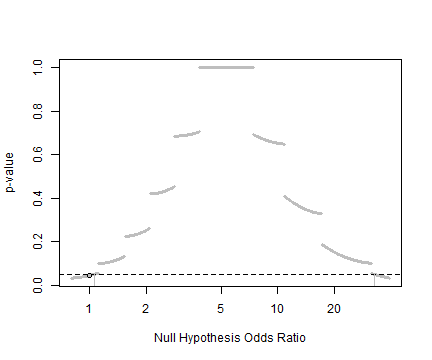

RObject{VecSxp}

	Two-sided Fisher's Exact Test (usual method using minimum likelihood)

data:  matrix(c(16, 4, 4, 6), 2, 2, byrow = T)
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  1.0549 32.6994
sample estimates:
odds ratio 
  5.585888 



In [9]:
R"""exact2x2::exact2x2(matrix(c(16, 4, 4, 6), 2, 2, byrow=T), plot=T)"""

In [10]:
R"""fisher.test(matrix(c(16, 4, 4, 6), 2, 2, byrow=T))"""

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  matrix(c(16, 4, 4, 6), 2, 2, byrow = T)
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



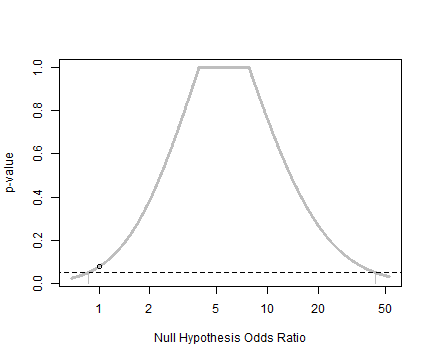

RObject{VecSxp}

	Central Fisher's Exact Test

data:  matrix(c(16, 4, 4, 6), 2, 2, byrow = T)
p-value = 0.07742
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



In [11]:
R"""exact2x2::exact2x2(matrix(c(16, 4, 4, 6), 2, 2, byrow=T), tsmethod="central", plot=T)"""

In [12]:
R"""epiR::epi.2by2(matrix(c(16, 4, 4, 6), 2, 2, byrow=T), digits=4)"""

RObject{VecSxp}
             Outcome +    Outcome -      Total        Inc risk *        Odds
Exposed +           16            4         20              80.0       4.000
Exposed -            4            6         10              40.0       0.667
Total               20           10         30              66.7       2.000

Point estimates and 95% CIs:
-------------------------------------------------------------------
Inc risk ratio                                 2.0000 (0.9076, 4.4072)
Odds ratio                                     6.0000 (1.1254, 31.9892)
Attrib risk in the exposed *                   40.0000 (4.9391, 75.0609)
Attrib fraction in the exposed (%)            50.0000 (-10.1794, 77.3097)
Attrib risk in the population *                26.6667 (-8.0681, 61.4014)
Attrib fraction in the population (%)         40.0000 (-13.8027, 68.3663)
-------------------------------------------------------------------
Yates corrected chi2 test that OR = 1: chi2(1) = 3.169 Pr>chi2 = 0.075
F

In [13]:
@show confint_rr_wald(16, 4, 4, 6);
@show confint_or_wald(16, 4, 4, 6);
@show confint_rr_pearson_chisq(16, 4, 4, 6);
@show confint_or_pearson_chisq(16, 4, 4, 6);
@show confint_or_pearson_chisq(16, 4, 4, 6; correction=0.5);
@show confint_or_fisher_sterne(16, 4, 4, 6);
@show confint_or_fisher_cp(16, 4, 4, 6);

confint_rr_wald(16, 4, 4, 6) = [0.9076108600427952, 4.407175118873516]
confint_or_wald(16, 4, 4, 6) = [1.1253809473171112, 31.989167833188734]
confint_rr_pearson_chisq(16, 4, 4, 6) = [1.0640380701223051, 4.855065400672167]
confint_or_pearson_chisq(16, 4, 4, 6) = [1.1911176901272547, 30.49633585876287]
confint_or_pearson_chisq(16, 4, 4, 6; correction = 0.5) = [0.8734133287988819, 47.22191280527804]
confint_or_fisher_sterne(16, 4, 4, 6) = [1.0548936562756726, 32.69944128327747]
confint_or_fisher_cp(16, 4, 4, 6) = [0.8602702455780802, 43.981822628221444]


In [14]:
@show pvalue_rr_wald(16, 4, 4, 6);
@show pvalue_or_wald(16, 4, 4, 6);
@show pvalue_rr_pearson_chisq(16, 4, 4, 6);
@show pvalue_or_pearson_chisq(16, 4, 4, 6);
@show pvalue_or_pearson_chisq(16, 4, 4, 6; correction=0.5);
@show pvalue_or_fisher_sterne(16, 4, 4, 6);
@show pvalue_or_fisher_cp(16, 4, 4, 6);

pvalue_rr_wald(16, 4, 4, 6) = 0.08552581801836596
pvalue_or_wald(16, 4, 4, 6) = 0.0358791966995754
pvalue_rr_pearson_chisq(16, 4, 4, 6) = 0.028459736916310572
pvalue_or_pearson_chisq(16, 4, 4, 6) = 0.028459736916310572
pvalue_or_pearson_chisq(16, 4, 4, 6; correction = 0.5) = 0.07505987281783365
pvalue_or_fisher_sterne(16, 4, 4, 6) = 0.04485792401834372
pvalue_or_fisher_cp(16, 4, 4, 6) = 0.0774172354382248


## RCall.jlの使い方

In [15]:
using RCall

In [16]:
A = [
    16 4
     4 6
]
@rput A

2×2 Matrix{Int64}:
 16  4
  4  6

In [17]:
R"""result = fisher.test(A)"""

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  A
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



In [18]:
@rget result

OrderedCollections.OrderedDict{Symbol, Any} with 7 entries:
  :p_value     => 0.0448579
  :conf_int    => [0.860291, 44.0017]
  :estimate    => 5.58589
  :null_value  => 1.0
  :alternative => "two.sided"
  :method      => "Fisher's Exact Test for Count Data"
  :data_name   => "A"

In [19]:
result[:p_value]

0.04485792401834373

In [20]:
result[:conf_int]

2-element Vector{Float64}:
  0.8602909481155422
 44.00171912708482

In [21]:
@rimport stats as stats
stats.fisher_test(A, var"conf.level"=0.99)

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  structure(c(16L, 4L, 4L, 6L), dim = c(2L, 2L))
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
99 percent confidence interval:
  0.5311819 80.4160043
sample estimates:
odds ratio 
  5.585888 



In [22]:
result_r = stats.fisher_test(A)

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  structure(c(16L, 4L, 4L, 6L), dim = c(2L, 2L))
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



In [23]:
result_julia = rcopy(result_r)

OrderedCollections.OrderedDict{Symbol, Any} with 7 entries:
  :p_value     => 0.0448579
  :conf_int    => [0.860291, 44.0017]
  :estimate    => 5.58589
  :null_value  => 1.0
  :alternative => "two.sided"
  :method      => "Fisher's Exact Test for Count Data"
  :data_name   => "structure(c(16L, 4L, 4L, 6L), dim = c(2L, 2L))"

In [24]:
result_julia[:p_value]

0.04485792401834373

In [25]:
result_julia[:conf_int]

2-element Vector{Float64}:
  0.8602909481155422
 44.00171912708482

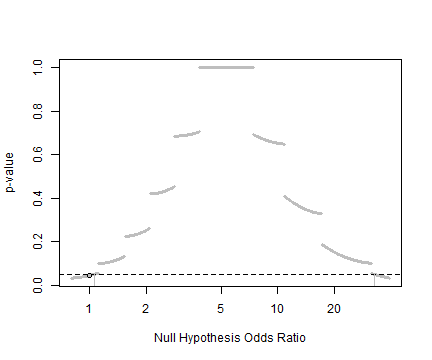

RObject{VecSxp}

	Two-sided Fisher's Exact Test (usual method using minimum likelihood)

data:  structure(c(16L, 4L, 4L, 6L), dim = c(2L, 2L))
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  1.0549 32.6994
sample estimates:
odds ratio 
  5.585888 



In [26]:
@rimport exact2x2 as exact2x2
exact2x2.exact2x2(A, plot="T")

In [27]:
@rimport epiR as epiR
epiR.epi_2by2(A, digits=4)

RObject{VecSxp}
             Outcome +    Outcome -      Total        Inc risk *        Odds
Exposed +           16            4         20              80.0       4.000
Exposed -            4            6         10              40.0       0.667
Total               20           10         30              66.7       2.000

Point estimates and 95% CIs:
-------------------------------------------------------------------
Inc risk ratio                                 2.0000 (0.9076, 4.4072)
Odds ratio                                     6.0000 (1.1254, 31.9892)
Attrib risk in the exposed *                   40.0000 (4.9391, 75.0609)
Attrib fraction in the exposed (%)            50.0000 (-10.1794, 77.3097)
Attrib risk in the population *                26.6667 (-8.0681, 61.4014)
Attrib fraction in the population (%)         40.0000 (-13.8027, 68.3663)
-------------------------------------------------------------------
Yates corrected chi2 test that OR = 1: chi2(1) = 3.169 Pr>chi2 = 0.075
F

In [28]:
using RCall

diamonds = R"""ggplot2::diamonds""" |> rcopy
first(diamonds, 10)

,carat,cut,color,clarity,depth,table,price,x,y,z
,Float64,Cat…,Cat…,Cat…,Float64,Float64,Int64,Float64,Float64,Float64
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.2,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49


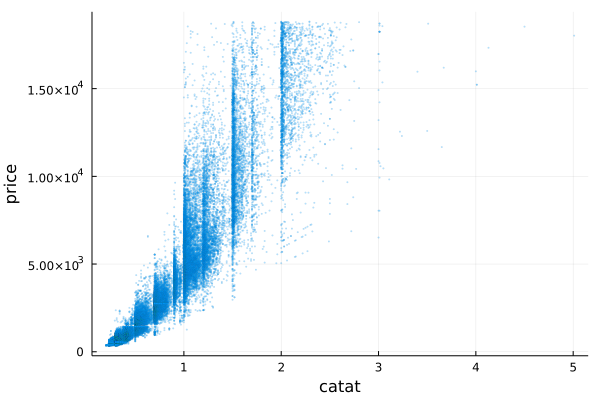

In [29]:
using StatsPlots
default(fmt=:png)
@df diamonds scatter(:carat, :price; label="", xguide="catat", yguide="price", msw=0, ms=1, alpha=0.3)

In [30]:
@rlibrary ggplot2

┌ Warning: RCall.jl: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
└ @ RCall D:\.julia\packages\RCall\6kphM\src\io.jl:172


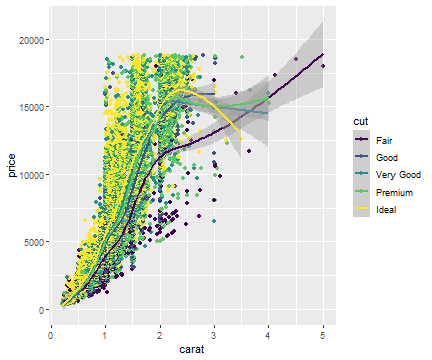

RObject{VecSxp}


In [31]:
ggplot(diamonds) +
geom_point(aes(x=:carat, y=:price, color=:cut)) +
geom_smooth(aes(x=:carat, y=:price, color=:cut))

See also https://nbviewer.org/gist/genkuroki/64602cfbdc95a2604b6b2a967eea6109